## Introduction
Directly editted in the shared LaTex doc. Please feel free to review and revise! :)

## Reading data

In [1]:
from __future__ import division
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import itertools
import random
%matplotlib inline

In [2]:
# Reading data
biyashee_colony_cnts = pd.read_csv('data/Bishayee Colony Counts 10.27.97-3.8.01.csv', skiprows=2)
biyashee_coulter_cnts = pd.read_csv('data/Bishayee Coulter Counts.10.20.97-7.16.01.csv', skiprows=1)
other_colony_cnts = pd.read_csv('data/Other Investigators in Lab.Colony Counts.4.23.92-11.27.02.csv', skiprows=1)
other_coulter_cnts = pd.read_csv('data/Other Investigators in Lab.Coulter Counts.4.15.92-5.21.05.csv', skiprows=1)
outside_coulter_cnts1 = pd.read_csv('data/Outside Lab 1.Coulter Counts.6.7.91-4.9.99.csv')
outside_coulter_cnts2 = pd.read_csv('data/Outside Lab 2.Coulter Counts.6.6.08-7.7.08.csv', skiprows=1)
outside_colony_cnts =  pd.read_csv('data/Outside Lab 3.Colony Counts.2.4.10-5.21.12.csv', skiprows=1)

# standardizing column names for dataframes
biyashee_colony_cnts.columns = ['Isotope', 'Bates', 'Date', 'c1', 'c2', 'c3', 'avg']
biyashee_coulter_cnts.columns = ['Bates', 'Date', 'c1', 'c2', 'c3', 'avg']
other_colony_cnts.columns = ['Bates', 'Date', 'Inv', 'c1', 'c2', 'c3', 'avg']
other_coulter_cnts.columns = ['Bates', 'Date', 'c1', 'c2', 'c3', 'avg', 'Inv']
outside_coulter_cnts1.columns = ['Experiment', 'c1', 'c2', 'c3', 'avg', 'Date']
outside_coulter_cnts2.columns = ['Date', 'c1', 'c2', 'c3', 'avg']
outside_colony_cnts.columns = ['Date', 'c1', 'c2', 'c3', 'avg']

# converting to numerics
biyashee_colony_cnts['c3'] = pd.to_numeric(biyashee_colony_cnts['c3'], errors = 'coerce')
other_colony_cnts['c3'] = pd.to_numeric(other_colony_cnts['c3'], errors = 'coerce')

# filling in experiment and date info
def fill_na(df, column):
    df[column] = df[column].fillna(method='ffill')

fill_na(outside_coulter_cnts1, 'Experiment')
fill_na(outside_coulter_cnts1, 'Date')
fill_na(outside_coulter_cnts2, 'Date')
fill_na(outside_colony_cnts, 'Date')

## Replicate Table 1 by Simulation

In [3]:
def MidProb(Lambda):
    j = 0
    N = 10000
    gap = 2
    for i in range(N):
        a = np.random.poisson(Lambda, 3)
        if max(a) - min(a) >= gap:
            if int(round(a.mean(),0)) in a:
                j += 1
        else:
            pass
    return j/N

## Triplicate Mean Count
### Replication
#### Hypothesis Testing 1

In [4]:
p = 0.42

n_triplicate_containing_avg = 690
n_samples = 1343
prob = stats.binom.sf(n_triplicate_containing_avg - 1, n_samples, p)
print 'RTS data: ', format(prob, '1.3E')

n_triplicate_containing_avg = 109
n_samples = 572
prob = stats.binom.sf(n_triplicate_containing_avg - 1, n_samples, p)
print 'Rest of the lab: ', format(prob, '1.3E')

RTS data:  2.853E-12
Rest of the lab:  1.000E+00


#### Hypothesis Testing II

### Alternative Test: Permutation Test ###

As an alternative test, we conducted permutation test on the same coulter and colony data sets to verify the conclusion from the earlier section. For this, we first pooled together all the sample data for coulter and colony counts respectively. We then drew random samples from the pool, where the size of the sample is equal to that of the RTS individual. Two methods were employed.  

Method 1: We first ran a simulation of 10,000 draws. In those 10,000 draws, we counted the number (and proportion) of draws containing equal or more mean-containing triplicates than that observed in RTS individual dataset. After running the simulation a couple times, we noticed that the number (and proportion) of draws containing more mean-containing triplicate is consistently 0. This preliminary test suggested that it is unlikely that the data in RTS individual dataset would have occured by chance.

Method 2: To get a more precise bound on the actual probability, we procede to calculate the probability analytically using a hypergeometric distribution. The exact probabilities of obtaining the same number of mean-containing triplicates as in the RTS individual's dataset was exceedingly small ($<10^-10$) for both coulter and colony datasets, thereby supporting our observation from method 1 and the earlier

We first ran a simulation of 10,000 draws. In those 10,000 draws, we counted the number (and proportion) of draws containing equal or more mean-containing triplicates than that observed in RTS individual dataset. After running the simulation a couple times, we noticed that the number (and proportion) of draws containing more mean-containing triplicate is consistently 0. This preliminary test suggested that it is unlikely that we got the data in RTS individual dataset by chance

Two forms of permutation tests were run. We first ran 

The authors excluded triplicates with adjacent counts, max(triplicate counts) - min(triplicate counts) <= 1, in their calculation. 

#### Helper functions ####

In [5]:
import warnings
warnings.filterwarnings('ignore')

# pool all samples for triplicate testing
def triplicate_pool_all_samples(dfs):
    samples = dfs[0][['c1', 'c2', 'c3']]
    for df in dfs[1:]:
        samples = samples.append(df[['c1', 'c2', 'c3']], ignore_index=True)
    return samples

# remove rows with adjacent count values 
def triplicate_remove_consecutives(df):
    '''remove triplicate rows with adjacent count values, i.e. max(triplicate count) - min(triplicate count) < 2'''
    return df[df[['c1', 'c2', 'c3']].max(axis=1) - df[['c1', 'c2', 'c3']].min(axis=1) >= 2]

def helper_contains_mean(df_row):
    '''returns true if any of c1, c2 or c3 equals the triplicate average '''
    return (df_row['mean'] == df_row['c1'] or 
            df_row['mean'] == df_row['c2'] or 
            df_row['mean'] == df_row['c3'])

# clean up data and add a new column to the data frame indicating if the triplicate contains its rounded mean
def triplicate_has_mean(df):
    '''append df with an extra column of booleans indicating if each row of triplicate contains its own mean'''
    # drop NA values and convert c1, c2, c3 to int type
    df = df.dropna()
    df[['c1', 'c2', 'c3']] = df[['c1', 'c2', 'c3']].astype(int)
    
    # calculate mean and append a new column of mean values to df
    df['mean'] = df.mean(axis=1).round(0).astype(int)

    # calculate if each row of triplicate contains its own mean and append a new boolean column to df
    df['contains_mean'] = df.apply(helper_contains_mean, axis=1)
    
    return df

#### Step 1. Pool all the samples ####

In [6]:
coulter_dfs = [biyashee_coulter_cnts,
               other_coulter_cnts,
               outside_coulter_cnts1,
               outside_coulter_cnts2]

colony_dfs = [biyashee_colony_cnts,
              other_colony_cnts,
              outside_colony_cnts]

coulter_samples = triplicate_pool_all_samples(coulter_dfs)
colony_samples = triplicate_pool_all_samples(colony_dfs)

#### Step 2. Check for mean-containing triplicate in the pooled samples ####

In [7]:
coulter_samples_mean = triplicate_has_mean(coulter_samples)
colony_samples_mean = triplicate_has_mean(colony_samples)

#### Step 3. Permutation test functions for triplicate count test ####
We implemented 2 types of permutation tests. One performed simulations of n_sim random samplings, and the other calculated the theoretical probability of obtaining test_statisc or more of mean-containing triplicates.

In [8]:
def tri_perm_test_sampling(pooled_samples, n, n_perm, test_statistic):
    '''permutation test for triplicate mean counts'''
    x = []
    for i in range(n_perm):
        x.append(sum(random.sample(pooled_samples, n)))
    x = np.asarray(x)
    print "Ploting permutation histogram with random ", n_perm, " samplings"
    plt.hist(x, bins=100)
    plt.show()
    print "maximum values in the permutation sampling: ", max(x)

    return np.count_nonzero(x >= test_statistic) / float(len(x))

def tri_perm_test_theoretical(pooled_samples, n, test_statistic):
    '''permutation test for triplicate mean counts
    pooled_samples should be a series'''
    
    # rv is the hypergeometric variable in question
    rv = stats.hypergeom(pooled_samples.size, pooled_samples.sum(), n)
    
    # Plotting a sample draw (optional)
    (lower, upper) = rv.interval(0.9999)
    x = np.arange(lower, upper)
    print "Ploting hypergeometric pmf with n equal to ", n
    plt.plot(x, rv.pmf(x))
    plt.show()
    
    # pooled_samples.size is the total number of triplets
    # pooled_samples.sum() is the number of marked triplets
    # n is the number of sampels drawn
    return rv.sf(test_statistic - 1)

#### Step 4a. Perform the permutation test on all coulter and colony samples. ####

In [9]:
# values of n and test_statistic are obtained from PNAS paper Table 2 (pg 7)
n_coulter = 1727
n_colony = 1361
test_statistic_coulter = 177
test_statistic_colony = 708
n_sim = 10000

##### 4.a.1 Coulter Counts #####

Ploting permutation histogram with random  10000  samplings


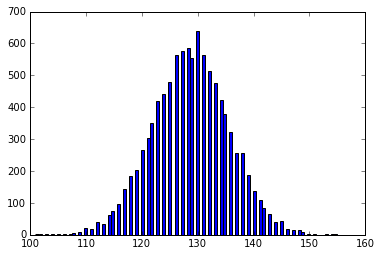

maximum values in the permutation sampling:  155


In [11]:
# permutation test by sampling on coulter samples (and plot the distribution histogram)
test_result_sampling = tri_perm_test_sampling(coulter_samples_mean['contains_mean'], n_coulter, n_sim, test_statistic_coulter)

 Ploting hypergeometric pmf with n equal to  1727


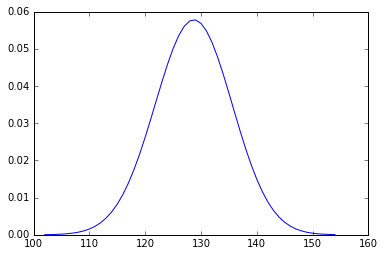

Permutation Test on Coulter Samples
Size of sameple:  1727
Test statistic:  177
Probability that sample permutation >= test statistic:  1.334E-13


In [14]:
# pmf of hypergeometric distribution for coulter samples
test_result_theory = tri_perm_test_theoretical(coulter_samples_mean['contains_mean'], n_coulter, test_statistic_coulter)

# print out key information as output
print "Permutation Test on Coulter Samples"
print "Size of sameple: ", n_coulter
print "Test statistic: ", test_statistic_coulter
print "Probability that sample permutation >= test statistic: ", format(test_result_theory, '1.3E')

##### 4.a.2 Colony Counts #####

Ploting permutation histogram with random  10000  samplings


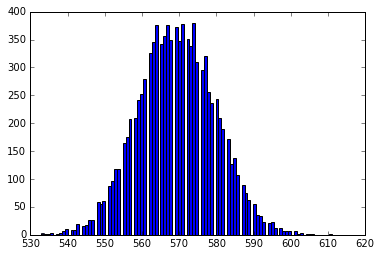

maximum values in the permutation sampling:  611


In [15]:
# permutation test by sampling on coulter samples (and plot the distribution histogram)
test_result_sampling = tri_perm_test_sampling(colony_samples_mean['contains_mean'], n_colony, n_sim, test_statistic_colony)

Ploting hypergeometric pmf with n equal to  1361


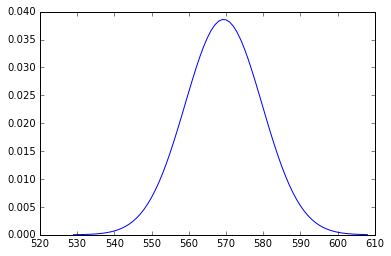

Permutation Test on Colony Samples
Size of sameple:  1361
Test statistic:  708
Probability that sampled permutation >= test statistic:  2.404E-43


In [16]:
# pmf of hypergeometric distribution for coulter samples
test_result_theory = tri_perm_test_theoretical(colony_samples_mean['contains_mean'], n_colony, test_statistic_colony)

# print out key information as output
print "Permutation Test on Colony Samples"
print "Size of sameple: ", n_colony
print "Test statistic: ", test_statistic_colony
print "Probability that sampled permutation >= test statistic: ", format(test_result_theory, '1.3E')

#### Step 4.b Perform the permutation test on all coulter and colony samples MINUS triplicates with adjacent counts. ####

In [17]:
n_coulter = 1726
n_colony = 1343
test_statistic_coulter = 173
test_statistic_colony = 690
n_sim = 10000

coulter_samples_mean = triplicate_remove_consecutives(coulter_samples_mean)
colony_samples_mean = triplicate_remove_consecutives(colony_samples_mean)

##### 4.b.1 Coulter Counts #####

Ploting permutation histogram with random  10000  samplings


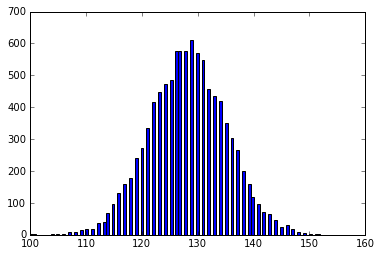

maximum values in the permutation sampling:  152


In [18]:
# permutation test by sampling on coulter samples (and plot the distribution histogram)
test_result_sampling = tri_perm_test_sampling(coulter_samples_mean['contains_mean'], n_coulter, n_sim, test_statistic_coulter)

Ploting hypergeometric pmf with n equal to  1726


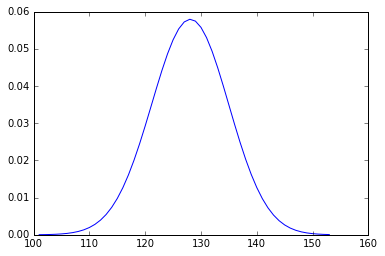

Permutation Test on Coulter Samples
Size of sameple:  1726
Test statistic:  173
Probability that sample permutation >= test statistic:  6.317E-12


In [19]:
# pmf of hypergeometric distribution for coulter samples
test_result_theory = tri_perm_test_theoretical(coulter_samples_mean['contains_mean'], n_coulter, test_statistic_coulter)

# print out key information as output
print "Permutation Test on Coulter Samples"
print "Size of sameple: ", n_coulter
print "Test statistic: ", test_statistic_coulter
print "Probability that sample permutation >= test statistic: ", format(test_result_theory, '1.3E')

##### 4.b.2 Colony Counts #####

Ploting permutation histogram with random  10000  samplings


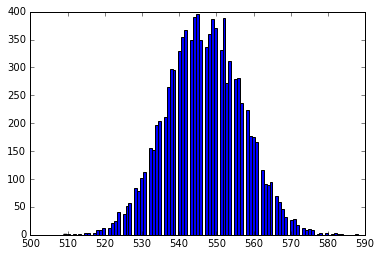

maximum values in the permutation sampling:  588


In [20]:
# permutation test by sampling on coulter samples (and plot the distribution histogram)
test_result_sampling = tri_perm_test_sampling(colony_samples_mean['contains_mean'], n_colony, n_sim, test_statistic_colony)

Ploting hypergeometric pmf with n equal to  1343


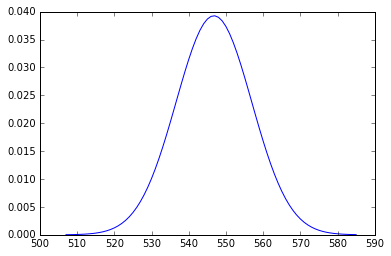

Permutation Test on Colony Samples
Size of sameple:  1343
Test statistic:  690
Probability that sampled permutation >= test statistic:  2.964E-48


In [21]:
# pmf of hypergeometric distribution for coulter samples
test_result_theory = tri_perm_test_theoretical(colony_samples_mean['contains_mean'], n_colony, test_statistic_colony)

# print out key information as output
print "Permutation Test on Colony Samples"
print "Size of sameple: ", n_colony
print "Test statistic: ", test_statistic_colony
print "Probability that sampled permutation >= test statistic: ", format(test_result_theory, '1.3E')

## Mid-ratio test

### Expeceted percent of samples with mid-ratio [.40,.60]
For all integer values of $\lambda$ from 1 to 2000, we simmulate 10,000 poisson triplicates and calculate the mid-ratio for each triplicate. Here the mid-ratio is defined as the ratio of the difference between the median and the smallest value of the triplicate to the difference between the largest and smallest value of the triplicate. 
We then calculate the percentage of mid-ratios that fall in the interval [0.4, 0.6]. Our results match with those reported in the paper - the percent of mid ratio test in the interval [0.4, 0.6] never exceeds 0.26.

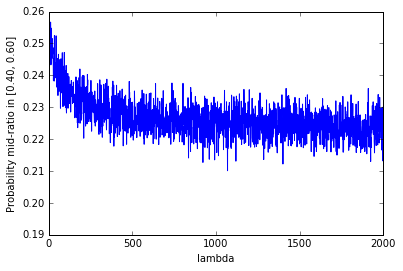

In [22]:
# simulate poison
def mid_ratio(x):
    # x = n x 3 matrix of poisson variables
    return (np.median(x,1)-np.min(x,1))/(np.max(x,1)-np.min(x,1))

def mid_ratio_40_60(x):
    # x = n-vector of mid-ratios
    # returns the percent of samples that have mid-ratio in [.40,.60]
    return np.count_nonzero((x>=.4) & (x<=.6))/float(len(x))

def midratio_poisson_tv(lam, n_sim):
    sim_poisson = stats.poisson.rvs(lam, size = 3*n_sim)
    sim_poisson = sim_poisson.reshape((-1,3))
    mid_ratios = mid_ratio(sim_poisson)
    return mid_ratio_40_60(mid_ratios)


v_midratio_poisson_tv = np.vectorize(midratio_poisson_tv)
# Range of mu we are plotting
x = np.arange(1, 2000)
plt.plot(x, v_midratio_poisson_tv(x, 10000))
plt.xlabel('lambda')
plt.ylabel('Probability mid-ratio in [0.40, 0.60]')
    

Pitt and Hill report that the RTS investigator has a high number of triplicates with a mid-ratio value in the interval [0.4, 0.6], but they do not actually report how unlikely such a result is.

From our investigation, we find that 824 of 1362 colony counts and 523 of 1729 coulter counts produced by the RTS investigator have a mid-ratio value in the interval [0.4, 0.6]. If, as Pitt and Hill suggest, we model the probability of mid-ratio in [0.4, 0.6] as a Bernouli process and conservatively assign the probability of success, p = 0.26, then the probability of observing 824 or more successes in 1362 colony count trials is 1.11e-16. The probability of observing 523 or more successes in 1729 coulter count triplicates is 3.26e-5. Both corroborate the idea that it is very unlikely that a Poisson process produced this many triplicates with midratios in the interval [0.4, 0.6]. 

However, we do take issue with the fact that Pitt and Hill decided to perform this test after observing "what appeared to be an unusual frequency of triples in RTS data containing a value close to their mean. Other investigators  besides RTS may well have trends that make their data look anomylous, and that would also have a low probability of happening by chance.

In [23]:
rts_mid_ratios_colony = mid_ratio(biyashee_colony_cnts[['c1','c2','c3']].values)
rts_mid_ratio_count_colony = mid_ratio_40_60(rts_mid_ratios_colony) * len(rts_mid_ratios_colony)
print '%i of %i RTS colony triplicates have mid-ratios in interval [0.4,0.6]' %(rts_mid_ratio_count_colony,
                                                                                len(rts_mid_ratios_colony))

rts_mid_ratios_coulter = mid_ratio(biyashee_coulter_cnts[['c1','c2','c3']].values)
rts_mid_ratio_count_coulter = mid_ratio_40_60(rts_mid_ratios_coulter) * len(rts_mid_ratios_coulter)
print '%i of %i RTS coulter triplicates have mid-ratios in interval [0.4,0.6]' %(rts_mid_ratio_count_coulter,
                                                                                len(rts_mid_ratios_coulter))

prob_rts_mid_ratio_colony = 1-stats.binom.cdf(rts_mid_ratio_count_colony,len(rts_mid_ratios_colony),.26)
prob_rts_mid_ratio_coulter =  1-stats.binom.cdf(rts_mid_ratio_count_coulter,len(rts_mid_ratios_coulter),.26)

print 'p of seeing at least %i of %i triplicates with mid-ratios in interval [0.4,0.6] = %.4g' %(
    rts_mid_ratio_count_colony,len(rts_mid_ratios_colony),prob_rts_mid_ratio_colony)
print 'p of seeing at least %i of %i triplicates with mid-ratios in interval [0.4,0.6] = %.4g' %(
    rts_mid_ratio_count_coulter,len(rts_mid_ratios_coulter),prob_rts_mid_ratio_coulter)

824 of 1362 RTS colony triplicates have mid-ratios in interval [0.4,0.6]
523 of 1729 RTS coulter triplicates have mid-ratios in interval [0.4,0.6]
p of seeing at least 824 of 1362 triplicates with mid-ratios in interval [0.4,0.6] = 1.11e-16
p of seeing at least 523 of 1729 triplicates with mid-ratios in interval [0.4,0.6] = 3.262e-05


## Terminal digits analysis
### Testing the assumptions
#### Is the terminal digit of a Poisson variable uniform?
For each $\mu$, we compute its total variation distance of the terminal digit distribution again the uniform distribution. We generate a vector containing 99.9% its probability mass. We reshape it into an array with 10 columns, allowing us to add the probability mass by terminal digits.

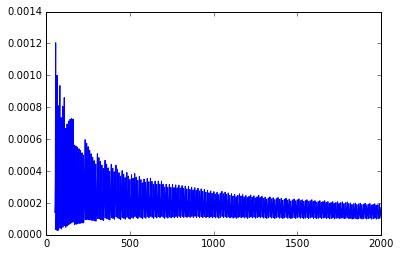

In [24]:
def termd_poisson_tv(mu):
    '''computes the total variation distance of the terminal digit distribution against uniform'''
    # Computes the probability mass, tail probability disregarded
    num_comp = np.ceil(stats.poisson.ppf(0.999, mu) / 10) * 10
    prob = stats.poisson.pmf(np.arange(num_comp), mu)
    # Normalization by 1-norm
    prob = prob / np.linalg.norm(prob, 1)
    # Reshaping prob into 10 columns so each row can be added
    prob = np.reshape(prob, (-1, 10))
    return np.linalg.norm(prob.sum(axis=0) - np.ones(10) / 10, 1)

v_termd_poisson_tv = np.vectorize(termd_poisson_tv)
# Range of mu we are plotting
x = np.arange(50, 2000)
plt.plot(x, v_termd_poisson_tv(x))

As observed above, the total variation distance is moderately close to 0. (The lack of convergence to 0 is due to the a truncated Poisson distribution is used in computation.) This validates the assumption.

#### Is the last two digits of a Poisson variable, conditioned on being three or more digits, the same approximately 10% of the time?

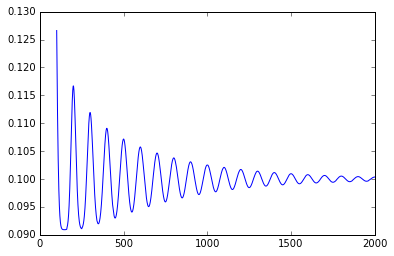

In [25]:
def term2d_poisson_tv(mu):
    '''computes the total variation distance of the terminal digit distribution against uniform'''
    # Computes the probability mass, tail probability disregarded
    num_comp = np.ceil(stats.poisson.ppf(0.999, mu) / 100) * 100
    prob = stats.poisson.pmf(np.arange(100, num_comp), mu)
    # Normalization by 1-norm
    prob = prob / np.linalg.norm(prob, 1)
    # Reshaping prob into 10 columns so each row can be added
    prob = np.reshape(prob, (-1, 100))
    return np.sum(prob[:, 0:100:11])

v_term2d_poisson_tv = np.vectorize(term2d_poisson_tv)
# Range of mu we are plotting
x = np.arange(100, 2000)
plt.plot(x, v_term2d_poisson_tv(x))

Since a lot of the counts by RTS are around 100, the assumption of 10% is not very valid in this regime. This is porticularly troublesome when the true parameter $\lambda$ is smaller than or comparable to 100. It is significantly more likely to observe 100 than 111, upsetting the uniform distribution assumption. Subject to imprecision of model specification, it does not seem that unlikely that RTS has a ~12% matching last two digits.

### Replication

In [26]:
def termd_count(df):
    '''counts the terminal digit in dataframe df. df must have c1, c2, c3'''
    c1_termd = df['c1'].mod(10).value_counts().sort_index()
    c2_termd = df['c2'].mod(10).value_counts().sort_index()
    c3_termd = df['c3'].mod(10).value_counts().sort_index()
    return list(c1_termd + c2_termd + c3_termd)

# corresponds to table 3 in Pitt and Hill
table3 = pd.DataFrame([termd_count(biyashee_colony_cnts),
                       termd_count(biyashee_coulter_cnts),
                       termd_count(other_colony_cnts),
                       termd_count(other_coulter_cnts),
                       termd_count(outside_coulter_cnts1),
                       termd_count(outside_coulter_cnts2),
                       termd_count(outside_colony_cnts)],
                      columns = range(10))
table3['index'] = pd.Series(['biyashee_colony_cnts', 'biyashee_coulter_cnts',
                             'other_colony_cnts', 'other_coulter_cnts',
                             'outside_coulter_cnts1', 'outside_coulter_cnts2',
                             'outside_colony_cnts'],
                            index=table3.index)
table3.set_index('index', inplace=True)
table3.index.name = None
table3['total'] = table3.sum(axis=1)
table3['chi-square'] = 0
for i in range(10):
    table3['chi-square'] += (table3[i] - table3['total'] / 10) ** 2 / (table3['total'] / 10)
table3['p'] = stats.chisqprob(table3['chi-square'], 9)
table3

,0,1,2,3,4,5,6,7,8,9,total,chi-square,p
biyashee_colony_cnts,564,324,463,313,290,478,336,408,383,526,4085,200.725826,2.333780e-38
biyashee_coulter_cnts,475,613,736,416,335,732,363,425,372,718,5185,466.874638,7.062273e-95
other_colony_cnts,191,181,195,179,184,175,178,185,185,181,1834,1.790622,9.943625e-01
other_coulter_cnts,261,311,295,259,318,290,298,283,331,296,2942,15.994562,6.699524e-02
outside_coulter_cnts1,28,34,29,25,27,36,44,33,26,33,315,9.476190,3.945273e-01
outside_coulter_cnts2,34,38,45,35,32,42,31,35,35,33,360,4.944444,8.391240e-01
outside_colony_cnts,21,9,15,16,19,19,9,19,11,12,150,12.133333,2.058966e-01


Although the `total` column in the paper does not add up correctly, fixing it did not change the p-values much.

### Alternative analysis: Permutation test

Step 1. Pool all the samples together.

In [27]:
# pool all samples:
def pool_all_samples(dfs):
    samples = np.array([])
    for df in dfs:
        samples = np.append(samples,df[['c1','c2','c3']].values.flatten())
    return samples

coulter_dfs = [biyashee_coulter_cnts,
               other_coulter_cnts,
               outside_coulter_cnts1,
               outside_coulter_cnts2]

colony_dfs = [biyashee_colony_cnts,
              other_colony_cnts,
              outside_colony_cnts]


coulter_samples = pool_all_samples(coulter_dfs)
colony_samples = pool_all_samples(colony_dfs)

Step 2. Permutation test for how far sample is from uniform

In [28]:
def chi_squared_term_digit(samples):
    chi_squared = 0
    termd = samples%10
    for i in range(10):
        ni = np.count_nonzero(termd == i)
        N = len(samples) # TODO fix to remove non-numbers
        chi_squared += (ni - N / 10.) ** 2 / (N / 10)
    return chi_squared
        

def perm_test(pooled_samples, n, n_perm, test_statistic):
    '''
    pooled_samples = all samples 
    n = number of samples in group of interest
    test_statistic = value of observed test statistic to plot against
    n_iter = number of iterations
    '''
    test_statistics = np.array([])
    for i in range(n_perm):
        # take 1st n samples
        samples = pooled_samples[np.random.permutation(len(pooled_samples))[0:n]]  #array(i[0:n])
        # compute test statistic on these samples
        test_statistics = np.append(test_statistics, chi_squared_term_digit(samples))

    # Plotting a sample draw (optional)
    plt.hist(test_statistics, bins=50)
    plt.show()
    
    return np.count_nonzero(test_statistics>test_statistic)/float(len(test_statistics))

Step 3a. Perform the permutation test on coulter samples.

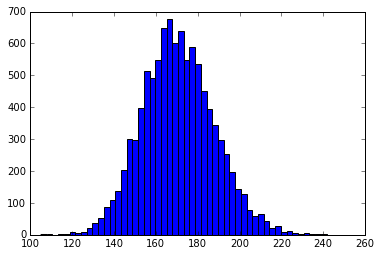

Permutation Test on Coulter Samples
Size of sameple:  5187
Test statistic:  466.695392327
Probability that sample permutation >= test statistic:  0.000E+00


In [29]:
test_samples = pool_all_samples([biyashee_coulter_cnts])
n = len(test_samples)
n_perm = 10000
test_statistic = chi_squared_term_digit(test_samples)
test_result = perm_test(coulter_samples, n, n_perm, test_statistic)

print "Permutation Test on Coulter Samples"
print "Size of sameple: ", n
print "Test statistic: ", test_statistic
print "Probability that sample permutation >= test statistic: ", format(test_result, '1.3E')

Step 3b. Perform the permutation test on colony samples.

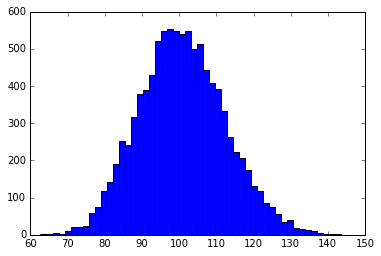

Permutation Test on Coulter Samples
Size of sameple:  4086
Test statistic:  200.676945668
Probability that sample permutation >= test statistic:  0.000E+00


In [30]:
test_samples = pool_all_samples([biyashee_colony_cnts])
n = len(test_samples)
n_perm = 10000
test_statistic = chi_squared_term_digit(test_samples)
test_result = perm_test(colony_samples, n, n_perm, test_statistic)

print "Permutation Test on Coulter Samples"
print "Size of sameple: ", n
print "Test statistic: ", test_statistic
print "Probability that sample permutation >= test statistic: ", format(test_result, '1.3E')